In [1]:
# === Imports de base ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# === Keras / Deep Learning ===
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, SGD, Adam


2025-11-10 09:17:33.223781: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-10 09:17:33.657839: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-10 09:17:36.739499: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


# Afficher les images

In [2]:
# Taille de l'image
picture_size = 50

# Dossier contenant les images
folder_path = "../data/images/train/disgusted"

# Classe à afficher
expression = 'disgusted'

# Affichage de 9 images de la classe choisie
plt.figure(figsize=(20, 20))

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

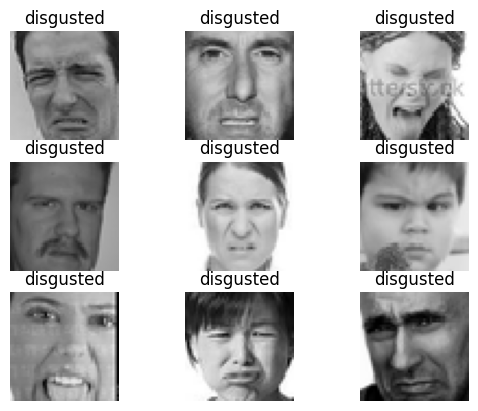

In [3]:
# Boucle pour afficher 9 images
for i in range(9):
    # Prendre le nom de l'image
    img_name = os.listdir(folder_path)[i]

    # Charger l'image et la redimensionner
    img = load_img(os.path.join(folder_path, img_name), target_size=(picture_size, picture_size))

    # Afficher l'image
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('disgusted')

plt.show()

# Création des données d’entraînement et de validation

In [4]:
# Taille des images
# picture_size = 48
picture_size = (48, 48)
# Chemin des dossiers
folder_path = "../data/images"

# Taille du lot (nombre d'images traitées à la fois)
batch_size = 128


"""
Normalise les pixels d'images de l'intervalle [0, 255] vers [0, 1] en multipliant par 1/255.
Cette normalisation uniforme aide à stabiliser l'entraînement et favorise la convergence du modèle.

Pourquoi on a deux générateurs?
datagen_train → pour les images d'entraînement
datagen_val → pour les images de validation
"""
# Générateurs d'images (pour charger et préparer les données)
datagen_train = ImageDataGenerator(rescale=1./255)     # Normalisation des pixels entre 0 et 1
datagen_val = ImageDataGenerator(rescale=1./255)



### ImageDataGenerator de Keras

La classe **ImageDataGenerator** de Keras est un outil puissant pour l'augmentation et le 
prétraitement des images lors de l'entraînement de modèles de deep learning.

#### Fonctionnalités principales
- Génère des lots (batches) de tenseurs d'images avec des transformations en temps réel,
  permettant au modèle d'apprendre des représentations robustes à partir d'un dataset
  diversifié.
- Utile lorsque les données sont limitées, car elle étend efficacement le dataset via
  des transformations comme rotations, décalages, flips et zooms.

#### Paramètres d'augmentation courants
- **rotation_range** : rotations aléatoires  
- **width_shift_range**, **height_shift_range** : décalages horizontaux et verticaux  
- **shear_range** : cisaillement  
- **zoom_range** : zooms aléatoires  
- **horizontal_flip**, **vertical_flip** : retournements aléatoires  
- **fill_mode** : méthode pour remplir les pixels créés après transformation ('nearest', etc.)  
- **rescale** : normalisation des pixels, typiquement de [0, 255] vers [0, 1]  

#### Méthodes principales
- **flow_from_directory** : génère des lots à partir de fichiers organisés par dossier,
  attribue automatiquement les labels selon les noms de dossier et applique les augmentations.  
- **flow** : applique directement des transformations sur un dataset en mémoire.  
- **fit** : ajuste le centrage et la standardisation sur les données.  
- **standardize** : applique la normalisation calculée sur les lots d'entrée.  


In [5]:
train_dir = os.path.join(folder_path, "train")
val_dir = os.path.join(folder_path, "validation")

# ------------------- Générateur pour l'entraînement -------------------
# train_set = datagen_train.flow_from_directory(
#     train_dir,                                       
#     target_size=(picture_size, picture_size),       # Redimensionne toutes les images à la même taille
#     color_mode="grayscale",                         # Conversion des images en niveaux de gris
#     batch_size=batch_size,                           # Nombre d'images traitées à chaque itération
#     class_mode='categorical',                        # Plusieurs classes (émotions), encode en one-hot
#     shuffle=True                                    # Mélange les images à chaque époque pour améliorer l'apprentissage
# )
train_set = tf.keras.utils.image_dataset_from_directory(
    "../data/images/train",
    labels="inferred",
    label_mode="categorical",   # Comme avec class_mode='categorical'
    image_size=picture_size,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=True
)

# ------------------- Générateur pour la validation -------------------
# test_set = datagen_val.flow_from_directory(
#     val_dir,                                         
#     target_size=(picture_size, picture_size),       # Redimensionnement similaire à l'entraînement
#     color_mode="grayscale",                         # Images en niveaux de gris
#     batch_size=batch_size,                           # Taille des lots
#     class_mode='categorical',                        # Encodage des labels pour la validation
#     shuffle=False                                   # Pas besoin de mélanger, on veut évaluer sur le même ordre
# )
val_set = tf.keras.utils.image_dataset_from_directory(
    "../data/images/validation",
    labels="inferred",
    label_mode="categorical",
    image_size=picture_size,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=False
)

Found 28709 files belonging to 7 classes.


2025-11-10 09:17:39.802031: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 7178 files belonging to 7 classes.


In [6]:
# Fonction de normalisation
def normalize(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    return images, labels

train_set = train_set.map(normalize)
val_set = val_set.map(normalize)


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)


# Construction du modèle 

### Explications des principales couches d'un modèle CNN Keras

- **Sequential** : modèle simple, couche par couche.  
- **Conv2D** : couche de convolution, détecte les motifs dans l'image.  
- **MaxPooling2D** : réduit la taille des images tout en conservant les informations importantes.  
- **Flatten** : transforme les images 2D en vecteur 1D pour les couches denses.  
- **Dense** : couche entièrement connectée, utilisée pour la classification.  
- **Dropout** : empêche le surapprentissage en désactivant aléatoirement des neurones pendant l'entraînement.  


In [8]:
# 4 couches CNN avec filtres et max pooling → extraire les motifs des images

# Flatten → transformer en vecteur

# 2 couches denses avec Dropout → combiner les motifs appris

# Couche finale softmax → classification en 7 émotions


model = Sequential()

# 1ère couche CNN
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2ème couche CNN
model.add(Conv2D(128, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3ème couche CNN
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 4ème couche CNN
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten
model.add(Flatten())

# Couche Dense 1
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Couche Dense 2
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Couche de sortie (une neurone par émotion)
model.add(Dense(7, activation='softmax')) 


/home/manalfarouqi/.pyenv/versions/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compiler le modèle

In [9]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entraîner le modèle

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',        # on surveille la "perte" (loss) sur les données de validation
    patience=4,                # si aucune amélioration pendant 4 époques, on arrête l'entraînement
    restore_best_weights=True  # à la fin, on reprend les poids du meilleur modèle (on garde le meilleur, pas celui de la dernière époque)
)


checkpointer = ModelCheckpoint(
    filepath='model.weights.best.keras',  # nom du fichier pour sauvegarder le modèle
    verbose=1,                            # affiche un message quand le modèle est sauvegardé
    save_best_only=True                   # sauvegarde seulement le meilleur modèle (selon val_loss)
)
"""
But : sauvegarder ton modèle automatiquement à chaque amélioration sur les données de validation.
Le fichier model.weights.best.keras contiendra les poids du meilleur modèle que tu pourras recharger plus tard.
"""

reduce_learningrate = ReduceLROnPlateau(
    monitor='val_loss',     # On surveille la perte sur les données de validation.
    factor=0.2,             # On multiplie le learning rate actuel par 0.2 (réduction à 20%) quand la perte stagne.
    patience=3,             # On attend 3 époques sans amélioration avant de réduire le learning rate.
    verbose=1,              # Affiche un message quand le learning rate change.
    min_delta=0.0001        # La perte doit diminuer au moins de 0.0001 pour être considérée comme une amélioration.
)
"""
ReduceLROnPlateau est un callback qui sert à réduire automatiquement le taux d'apprentissage (learning rate) si le modèle n'apprend plus.

Pourquoi ?
=> Le learning rate est la vitesse à laquelle le modèle ajuste ses poids.
=> Si la perte (val_loss) stagne, réduire le learning rate permet au modèle de faire des ajustements plus fins pour mieux converger.
"""

Entrai_model = model.fit(
    train_set,
    validation_data=val_set,
    epochs=20,
    callbacks=[checkpointer, early_stopping, reduce_learningrate]
)


Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2501 - loss: 1.9631
Epoch 1: val_loss improved from None to 1.95904, saving model to model.weights.best.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 577s 3s/step - accuracy: 0.3001 - loss: 1.8163 - val_accuracy: 0.2575 - val_loss: 1.9590 - learning_rate: 0.0010
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4120 - loss: 1.5227
Epoch 2: val_loss improved from 1.95904 to 1.53574, saving model to model.weights.best.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 550s 2s/step - accuracy: 0.4374 - loss: 1.4608 - val_accuracy: 0.4185 - val_loss: 1.5357 - learning_rate: 0.0010
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4886 - loss: 1.3216
Epoch 3: val_loss improved from 1.53574 to 1.28134, saving model to model.weights.best.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 517s 2s/step - accuracy: 0.5044 - loss: 1.2888 - val_accuracy: 0.4997 - val_loss: 1.2813 - learning_rate: 0.0010
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [11]:
# Charger les poids correspondant à la meilleure précision de validation
model.load_weights('model.weights.best.keras')


# Évaluation du modèle

In [12]:
loss, accuracy = model.evaluate(val_set) # Demande au modèle de prédire sur toutes les images du dossier validation.

#? loss: Montre à quel point le modèle fait encore des erreurs (plus c'est bas, mieux c'est).
#? accuracy: Donne le pourcentage d'images correctement classées (plus c'est haut, mieux c'est).

print("=== Résultats de l'évaluation : ===")
print(f"Perte sur les données de validation : {loss:.4f}")
print(f"Précision sur les données de validation : {accuracy*100:.2f}%")


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 344ms/step - accuracy: 0.6376 - loss: 1.0023
=== Résultats de l'évaluation : ===
Perte sur les données de validation : 1.0023
Précision sur les données de validation : 63.76%


# Enregistrer le modèle

In [13]:
model.save("facial_detection_model.keras")